# Проект "Предсказание рисков сердечного приступа"

## Загрузка библиотек и подготовка данных

In [1]:
# УСТАНОВКА БИБЛИОТЕК

# машинное обучение
!pip install --upgrade scikit-learn

# библиотека визуализации недостающих данных
!pip install missingno

# библиотека для анализа корреляции данных
!pip install phik -q

# библиотека МО на Python
# !pip install --upgrade scikit-learn -q

!pip install optuna

# !pip install catboost

In [2]:
# ИМПОРТ БИБЛИОТЕК, МОДУЛЕЙ И КЛАССОВ

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import optuna
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# ЗАГРУЗКА МОДЕЛЕЙ
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 

# ПРЕОБРАЗОВАНИЕ, АНАЛИЗ ДАННЫХ ДЛЯ МО
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import plot_tree

# ЗАГРУЗКА МЕТРИК
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# ПАЙПЛАЙНЫ, ОПТИМИЗАЦИЯ, ОТБОР ПРИЗНАКОВ
from sklearn.pipeline import Pipeline
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import GridSearchCV
from optuna import distributions
from optuna import visualization 

# МОДУЛИ ДЛЯ ПРЕДСТАВЛЕНИЯ ДАННЫХ
from IPython.display import display  #, HTML
pd.set_option('display.float_format', '{:,.2f}'.format)
# display(HTML("<style>.container { width:50% !important; }</style>"))

# УСТАНОВКА КОНСТАНТ
TEST_SIZE = 0.25
RANDOM_STATE = 77

### Исследование датасетов

#### Импорт датасета heart_train

In [3]:
# импорт датасета heart_train
heart_train = pd.read_csv('heart_train.csv')  #C:/Masterskaya_1/

In [4]:
# первые строки датасета heart_train в виде таблицы
heart_train.head(3)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.36,0.73,0.07,1.00,1.00,1.00,1.00,1.00,0.54,...,3.00,0.33,0.00,0.23,0.05,0.04,Male,0.21,0.71,2664
1,1,0.20,0.33,0.05,1.00,1.00,0.00,0.00,1.00,0.07,...,3.00,0.83,0.00,0.15,0.02,0.00,Female,0.41,0.57,9287
2,2,0.61,0.86,0.06,1.00,0.00,1.00,1.00,1.00,0.94,...,2.00,1.00,0.00,0.23,0.05,0.04,Female,0.24,0.22,5379


In [5]:
# общая информация по датафрейму heart_train 
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

**БЕСПОЛЕЗНЫЕ ПРИЗНАКИ:** *Unnamed: 0*, *Family History*. Возможно, *Income*, но не удаляем пока до исследования данных.

In [6]:
# удаление бесполезных признаков из датасета heart_train с проверкой результата
heart_train = heart_train.drop(['Unnamed: 0', 'Family History'], axis = 1)

#проверка удаления бесполезных признаков
print('Количество признаков после удаления бесполезных:', heart_train.shape)

Количество признаков после удаления бесполезных: (8685, 26)


#### Импорт датасета heart_test

In [7]:
heart_test = pd.read_csv('heart_test.csv')  # C:/Masterskaya_1/

In [8]:
# первые строки датасета heart_test  в виде таблицы
heart_test.head(3)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.49,0.26,0.06,0.00,1.00,1.00,1.00,1.00,0.36,...,0.31,1.00,0.33,0.23,0.05,0.04,Male,0.28,0.37,7746
1,1,0.22,0.95,0.08,1.00,0.00,0.00,1.00,0.00,1.00,...,0.09,0.00,0.17,0.23,0.05,0.04,Female,0.70,0.44,4202
2,2,0.63,0.09,0.06,0.00,1.00,1.00,1.00,0.00,1.00,...,0.21,7.00,1.00,0.10,0.00,0.09,Male,0.46,0.78,6632


In [9]:
# общая информация по датафрейму heart_test 
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

**БЕСПОЛЕЗНЫЕ ПРИЗНАКИ:** *Unnamed: 0*, *Family History*. Возможно, *Income*, но не удаляем пока до исследования данных.

In [10]:
# удаление бесполезных признаков из датасета heart_train с проверкой результата
heart_test = heart_test.drop(['Unnamed: 0', 'Family History'], axis = 1)

#проверка удаления бесполезных признаков
print('Количество признаков после удаления бесполезных:', heart_test.shape)

Количество признаков после удаления бесполезных: (966, 25)


#### ВЫВОДЫ:

**1.** Выявлены и удалены из датасетов бесполезные признаки *Unnamed: 0* и *Family History*.

**2.** Признак *Income* предположительно также является бесполезным, но пока оставлен до проведения исследования данных.

**3.** В признаках *Diabetes, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week* датафрейма *heart_train* присутствуют пропуски.

### Предобработка данных

#### Приведение наименований столбцов датафреймов к одному стилю к одному стилю

In [11]:
# преобразования в датафрейме heart_train
heart_train.columns = map(str.lower, heart_train.columns)
heart_train.columns = heart_train.columns.str.replace('(', '')
heart_train.columns = heart_train.columns.str.replace(')', '')
heart_train.columns = heart_train.columns.str.replace(' ', '_')
heart_train.columns = heart_train.columns.str.replace('-', '_')
heart_train.columns = heart_train.columns.str.replace('_binary', '')

# проверка преобразования
heart_train.columns

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'smoking', 'obesity',
       'alcohol_consumption', 'exercise_hours_per_week', 'diet',
       'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk', 'blood_sugar', 'ck_mb', 'troponin', 'gender',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

In [12]:
# преобразования в датафрейме heart_test
heart_test.columns = map(str.lower, heart_test.columns)
heart_test.columns = heart_test.columns.str.replace('(', '')
heart_test.columns = heart_test.columns.str.replace(')', '')
heart_test.columns = heart_test.columns.str.replace(' ', '_')
heart_test.columns = heart_test.columns.str.replace('-', '_')
heart_test.columns = heart_test.columns.str.replace('_binary', '')

# проверка преобразования
heart_test.columns

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'smoking', 'obesity',
       'alcohol_consumption', 'exercise_hours_per_week', 'diet',
       'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day', 'blood_sugar',
       'ck_mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

#### Удаление строк с пропусками значений в признаках датафрейма heart_train

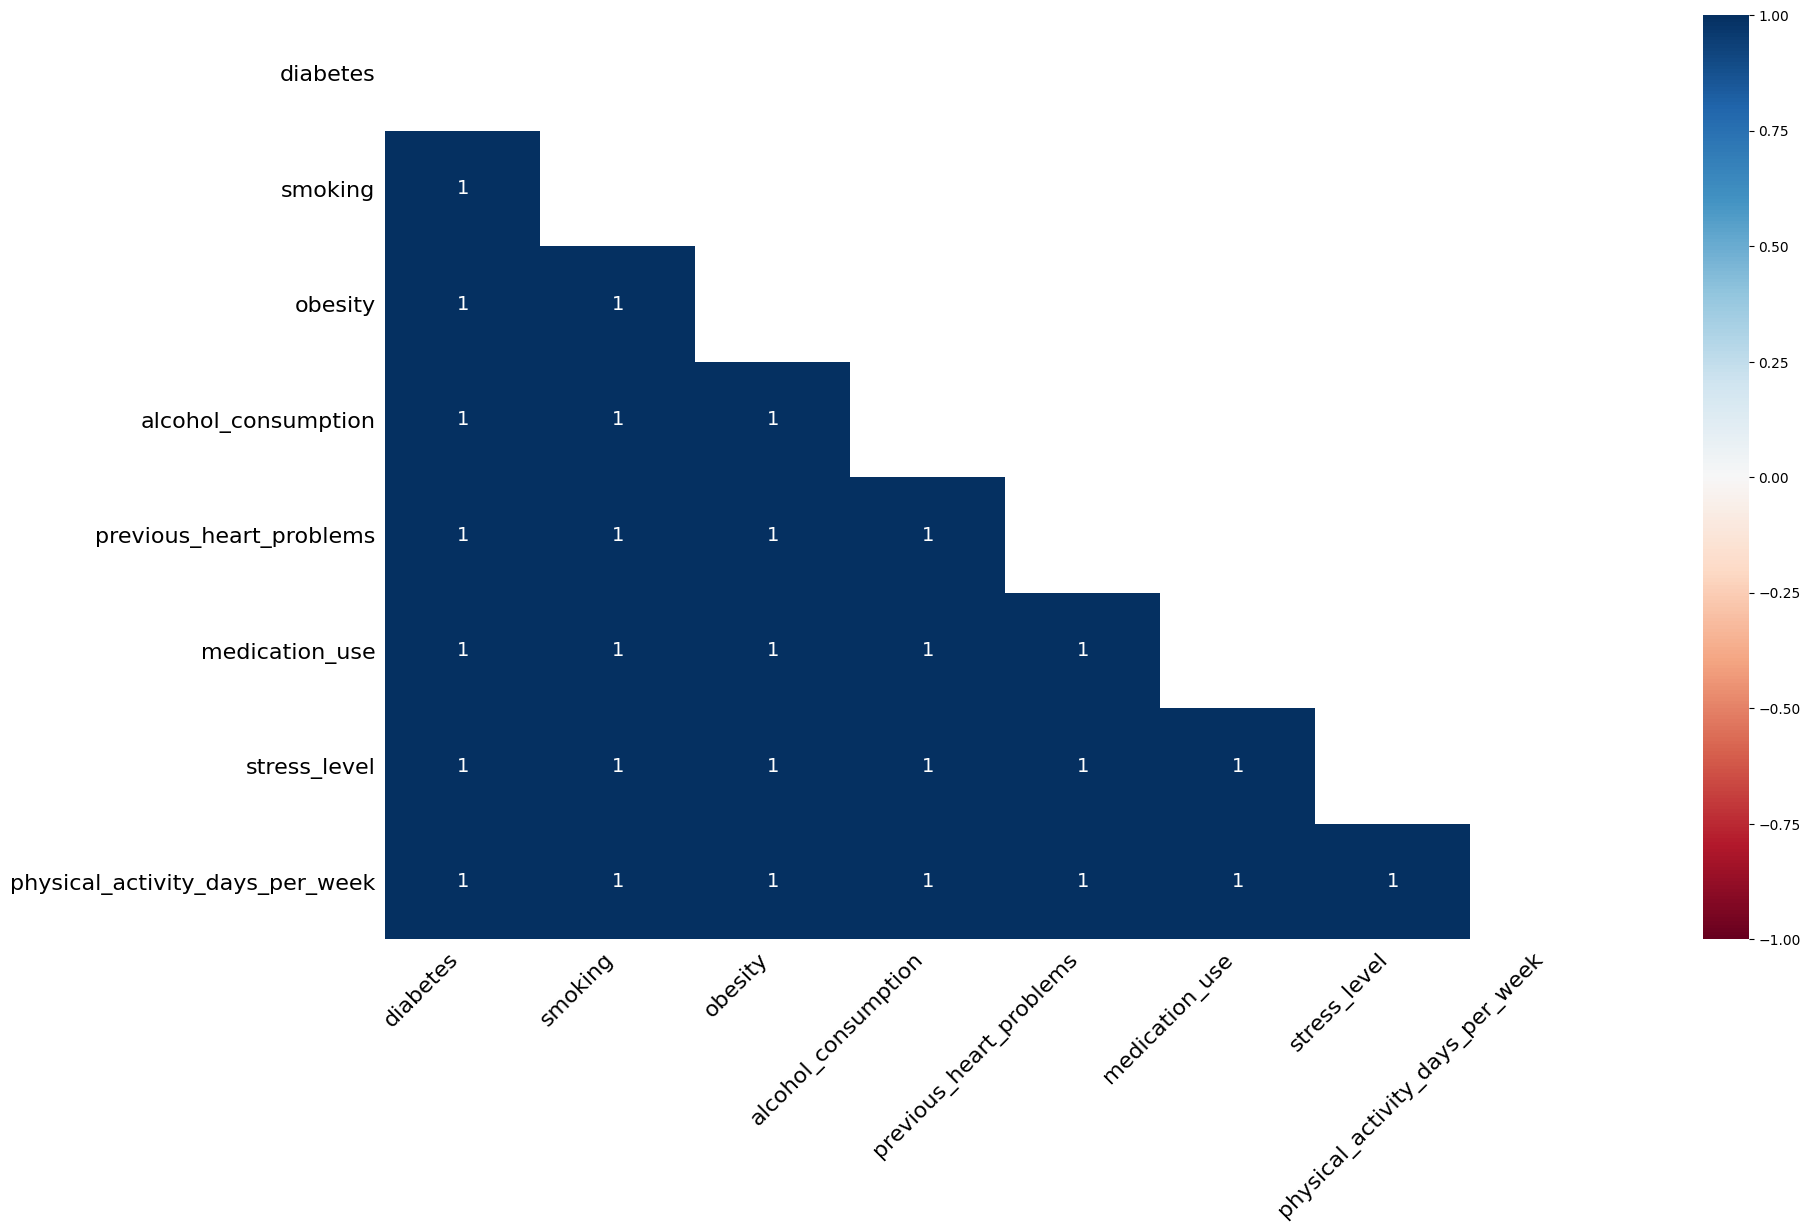

In [13]:
# общий обзор heart_train на наличие пропусков
msno.heatmap(heart_train);

In [14]:
# длина датафрейма до удаления строк с пропусками
len_1 = len(heart_train)
print('Длина датафрейма до удаления строк с пропусками:', len_1)

# удаление из датафрейма строк с одновременными пропусками в указанных ниже признаках
heart_train = heart_train.query('~diabetes.isna() and ~smoking.isna() and ~obesity.isna() \
                                and ~alcohol_consumption.isna() and ~previous_heart_problems.isna() \
                                and ~medication_use.isna() and ~stress_level.isna() \
                                and ~physical_activity_days_per_week.isna()'
                               )

# проверка удаления всех пропусков в признаках
print('Количество пропусков после их удаления в признаках:')
heart_train.isna().sum()

Длина датафрейма до удаления строк с пропусками: 8685
Количество пропусков после их удаления в признаках:


age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
heart_attack_risk                  0
blood_sugar                        0
ck_mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
id                                 0
dtype: int64

In [15]:
# длина датафрейма после удаления строк с пропусками, потери при удалении
len_2 = len(heart_train)
print('Длина датафрейма до удаления строк с пропусками:   ', len_1)
print('Длина датафрейма после удаления строк с пропусками:', len_2)
print('Количество удаленных строк с пропусками:           ', len_1 - len_2)
print(f'Количество удаленных строк с пропусками в %:        {(len_1 - len_2)*100/len_1:,.1f}')

Длина датафрейма до удаления строк с пропусками:    8685
Длина датафрейма после удаления строк с пропусками: 8442
Количество удаленных строк с пропусками:            243
Количество удаленных строк с пропусками в %:        2.8


#### Приведение дискретных признаков к целочисленному типу данных

In [16]:
heart_train[['diabetes', 'smoking', 'obesity', 'alcohol_consumption', \
             'previous_heart_problems', 'medication_use', 'stress_level', \
             'physical_activity_days_per_week', 'heart_attack_risk']] = \
heart_train[['diabetes', 'smoking', 'obesity', 'alcohol_consumption', \
             'previous_heart_problems', 'medication_use', 'stress_level', \
             'physical_activity_days_per_week', 'heart_attack_risk']].astype('int')

In [17]:
# проверка приведения к целочисленному типу данных дискретных признаков
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   int32  
 4   smoking                          8442 non-null   int32  
 5   obesity                          8442 non-null   int32  
 6   alcohol_consumption              8442 non-null   int32  
 7   exercise_hours_per_week          8442 non-null   float64
 8   diet                             8442 non-null   int64  
 9   previous_heart_problems          8442 non-null   int32  
 10  medication_use                   8442 non-null   int32  
 11  stress_level                     8442 non-null   int32  
 12  sedentary_hours_per_

#### ВЫВОДЫ:

**1.** В датасете 'heart_train' выявлены *243* строки с одновременным присутсвием пропусков в столбцах *'diabetes', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week'.* Принимая во внимание значительное отсутствие признакового описания в данных этих столбцов, а также их незначительное количество в составе датафрейма (*2,8%*), принято решение об их удалении.

**2.** Вещественный тип дискретных признаков *'diabetes', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week', 'heart_attack_risk'* преобразован в целочисленный.

### Исследовательский анализ данных

#### Ознакомление с общими статистическими характеристиками количественных признаков датафрейма

In [18]:
display(heart_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,"8,442.00",0.45,0.23,0.04,0.25,0.46,0.64,0.85
cholesterol,"8,442.00",0.50,0.29,0.00,0.26,0.50,0.75,1.00
heart_rate,"8,442.00",0.05,0.02,0.02,0.03,0.05,0.07,0.08
diabetes,"8,442.00",0.65,0.48,0.00,0.00,1.00,1.00,1.00
smoking,"8,442.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
obesity,"8,442.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00
alcohol_consumption,"8,442.00",0.60,0.49,0.00,0.00,1.00,1.00,1.00
exercise_hours_per_week,"8,442.00",0.50,0.29,0.00,0.25,0.51,0.75,1.00
diet,"8,442.00",1.00,0.81,0.00,0.00,1.00,2.00,2.00
previous_heart_problems,"8,442.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00


#### Функции визуализации количественных признаков датафреймов

In [19]:
# ФУНКЦИЯ ПОСТРОЕНИЯ ГИСТОГРАММ РАСПРЕДЕЛЕНИЯ КОЛИЧЕСТВЕННЫХ НЕПРЕРЫВНЫХ ПРИЗНАКОВ

def number_hist(
    file_name,
    file_name_str
    ) -> str:
    """ функция построение гистограмм количественных признаков
    Args:
        file_name: имя передаваемого датафрейма
        file_name_str: имя передаваемого датафрейма в формате str
    Values:
        list_2: список количественных признаков
    Returns:
        str: Гистограмма распределения значений признака
    """
    list_1 = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 
              'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 
              'blood_sugar', 'systolic_blood_pressure', 'diastolic_blood_pressure']
    for i in list_1:
        array_gr = file_name[i].to_numpy()
        plt.figure(figsize=(14, 3))
        bins =  plt.hist(array_gr, bins=100, density=True)
        plt.vlines(
            x=array_gr.mean(), 
            colors='red', 
            ymin=bins[0].min(), 
            ymax=bins[0].max(), 
            label='Среднее значение'
        )
        plt.title(f'Гистограмма распределения признака "{i}" датафрейма "{file_name_str}"')
        plt.legend()
        plt.ylabel('нормированная частота')
        plt.xlabel('значения признака');
        plt.figure(figsize=(14, 3))        
        plt.title(f'Boxplot для признака "{i}" датафрейма "{file_name_str}"')
        plt.boxplot(array_gr, vert=False)
        plt.ylabel('Boxplot')
        plt.xlabel('значения признака');
    return
    return

In [20]:
# ФУНКЦИЯ ПОСТРОЕНИЯ ГИСТОГРАММ РАСПРЕДЕЛЕНИЯ ДИСКРЕТНЫХ ПРИЗНАКОВ

def discret_count(
    file_name,
    list_1
    ) -> str:
    """ функция  графического представления категориальных признаков
    Args:
        file_name:  имя передаваемого датафрейма
        list_1: список дискретных признаков
    Values:  
    Returns:
        str: Гистограммаа распределения частот классов в признаке
    """
    for i in list_1:
        plt.figure(figsize=(12, 4))
        sns.countplot(data=file_name, x=i
                     ).set_title(f'Гистограмма распределения признака "{i}"');
        plt.ylabel('частота')
        plt.xlabel('значения признака')
        plt.show()      
    return
    return

#### Визуализация количественных непрерывных признаков

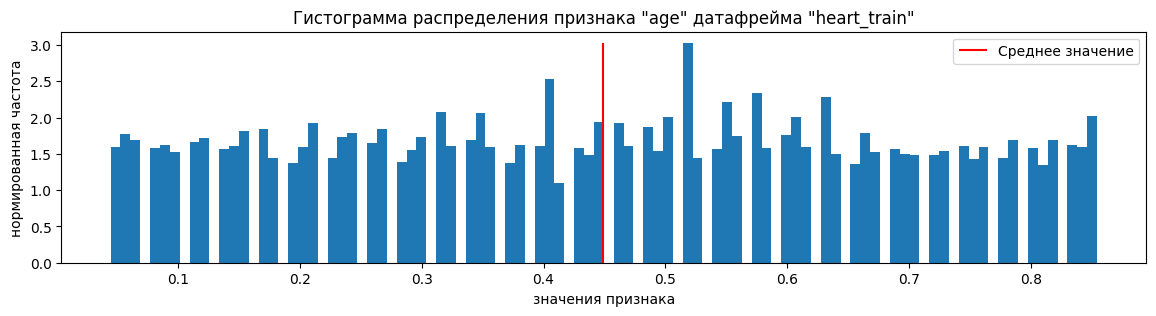

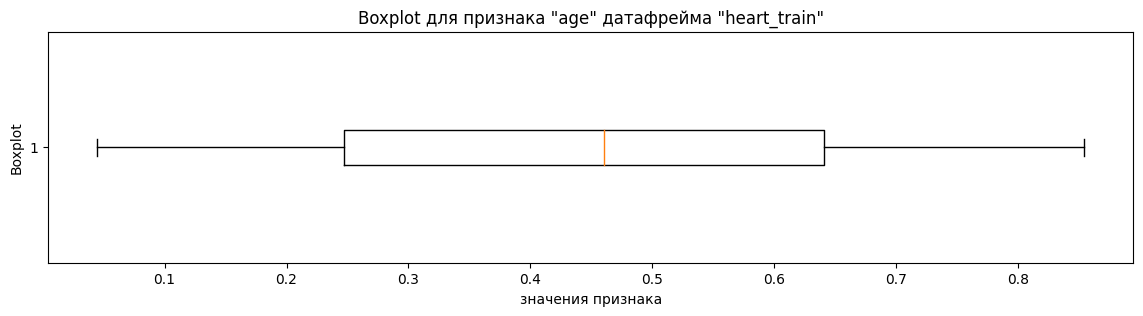

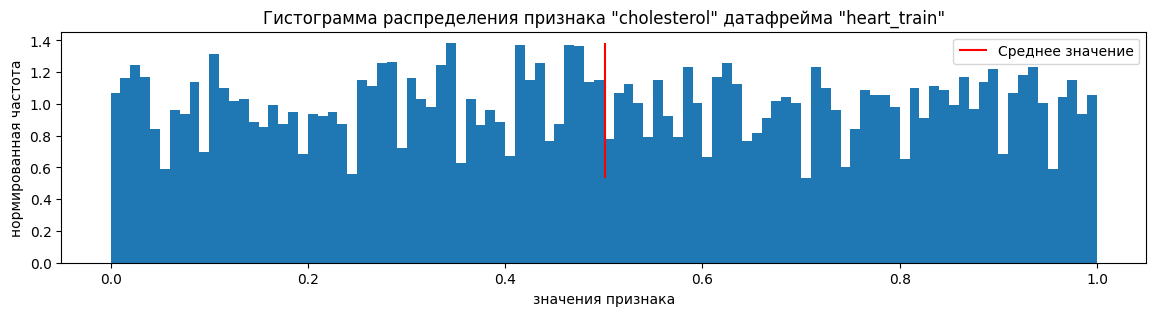

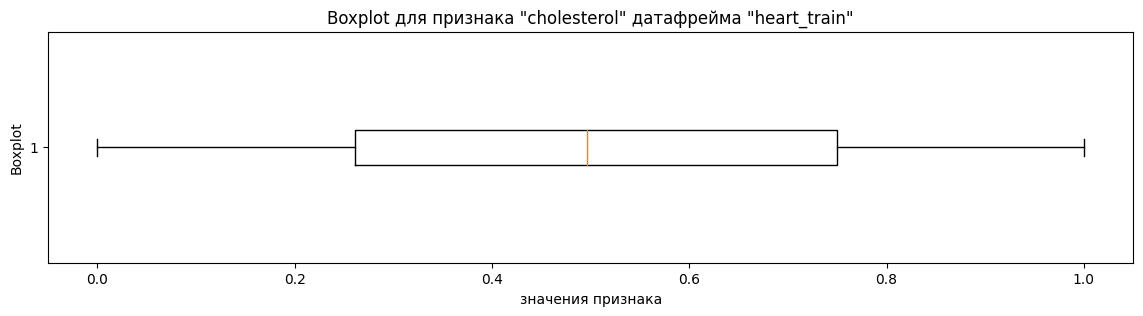

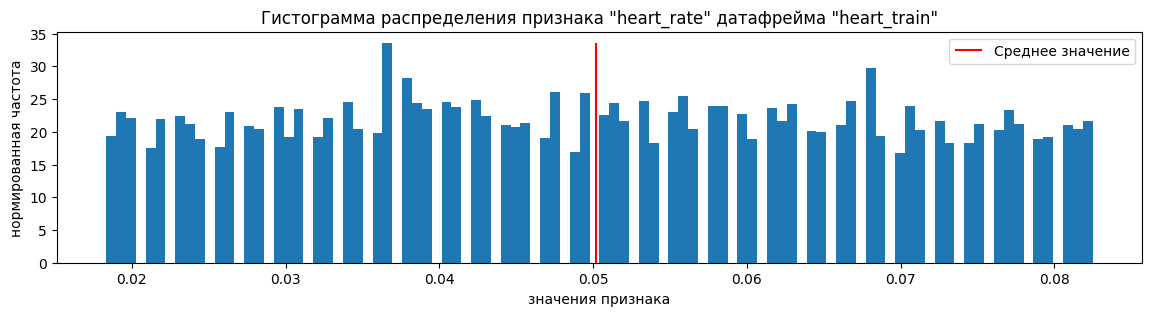

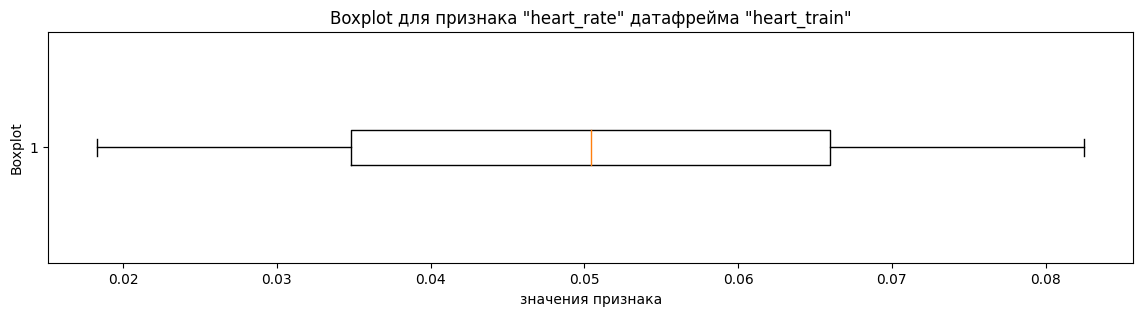

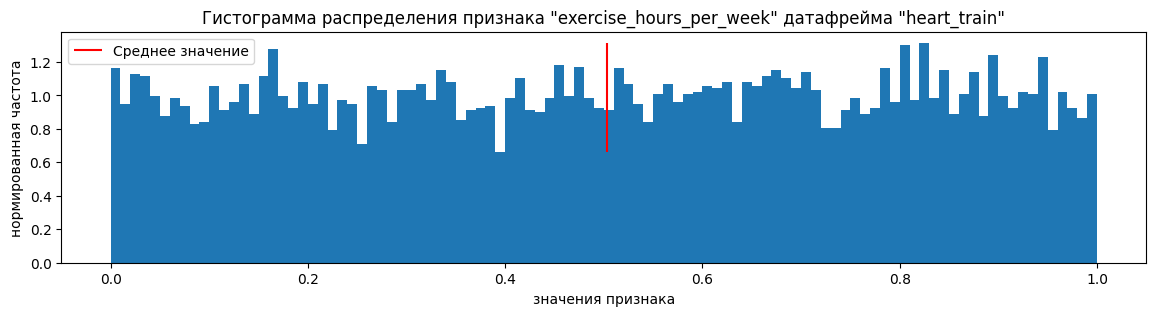

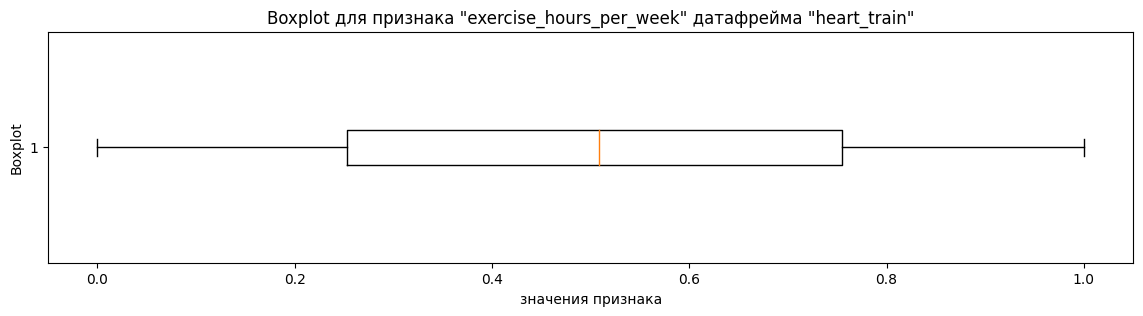

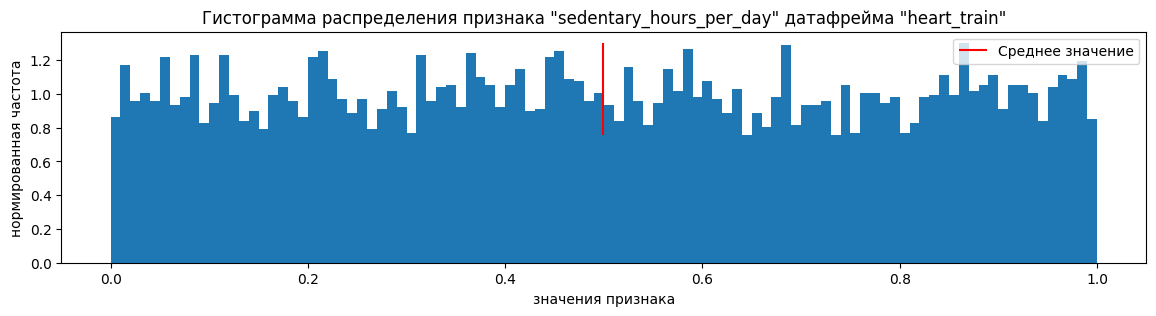

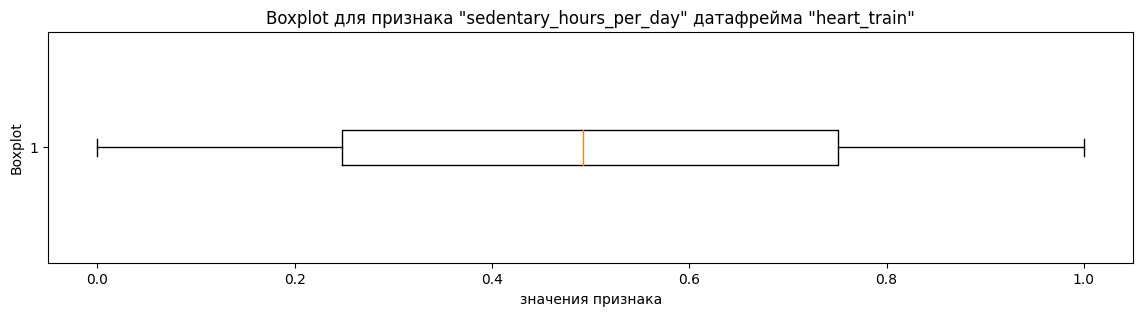

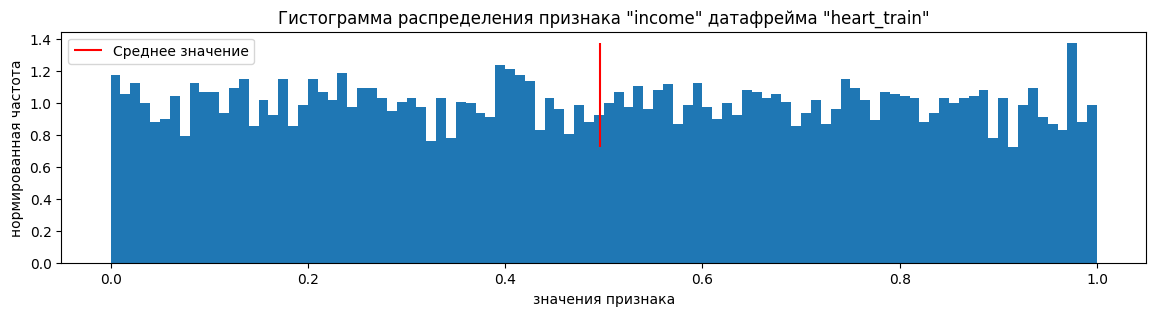

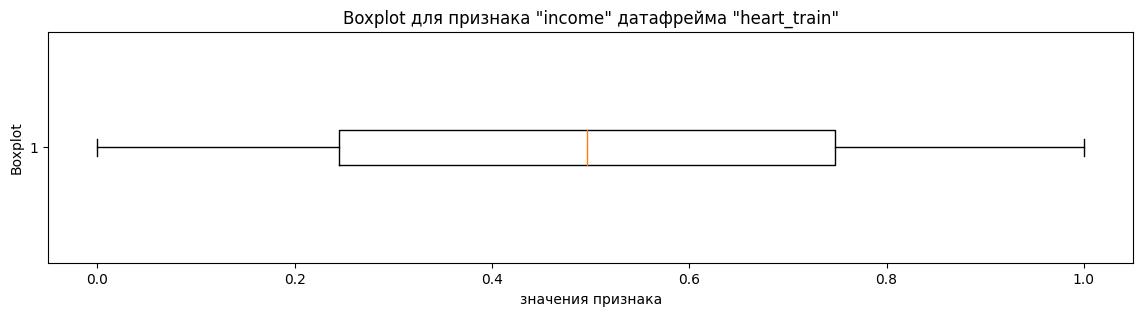

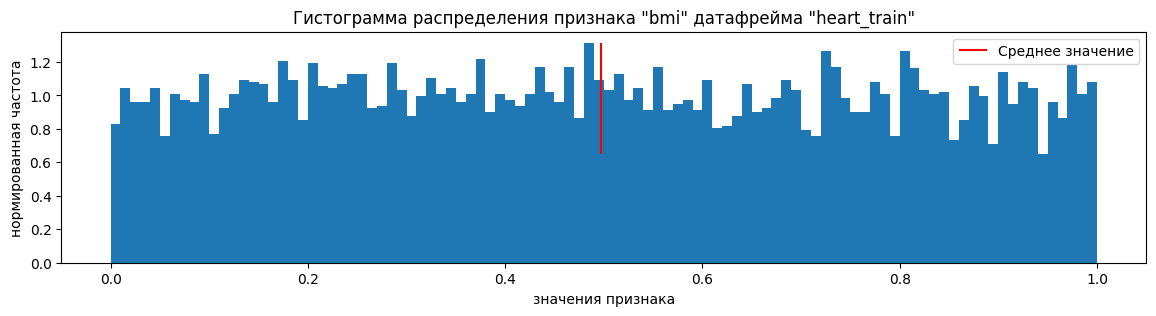

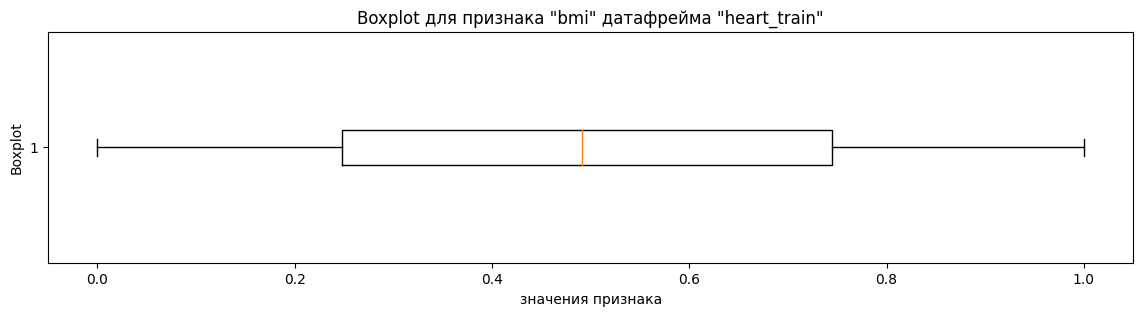

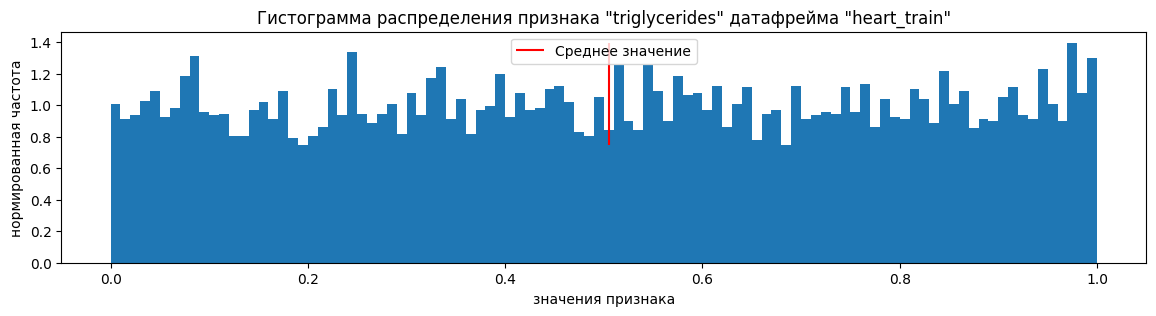

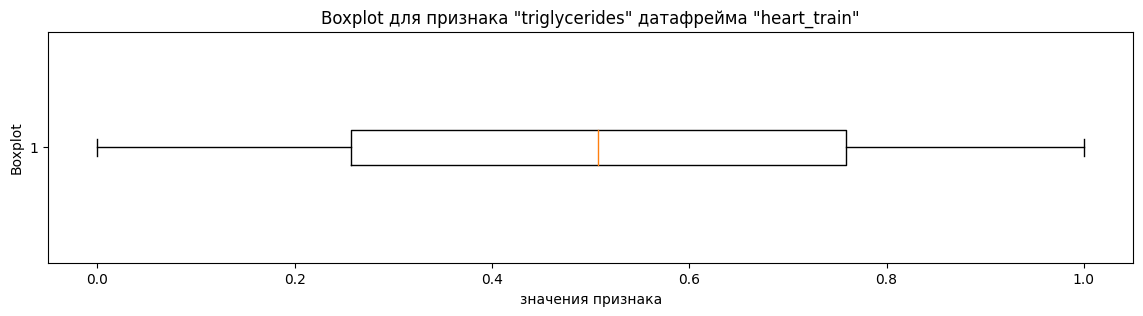

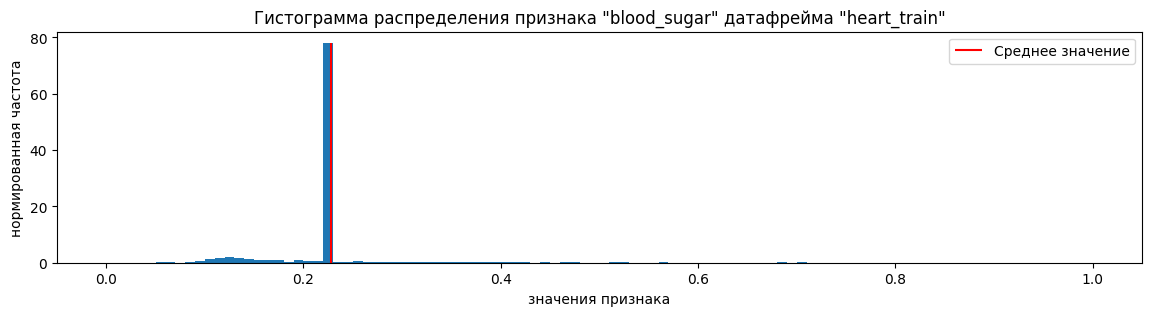

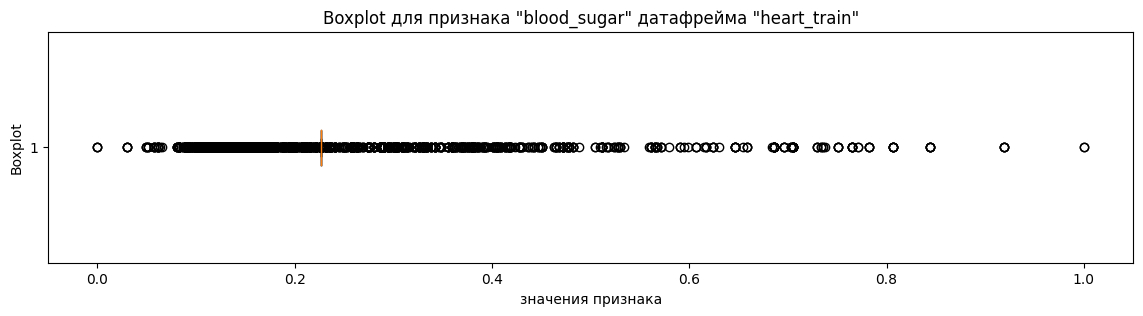

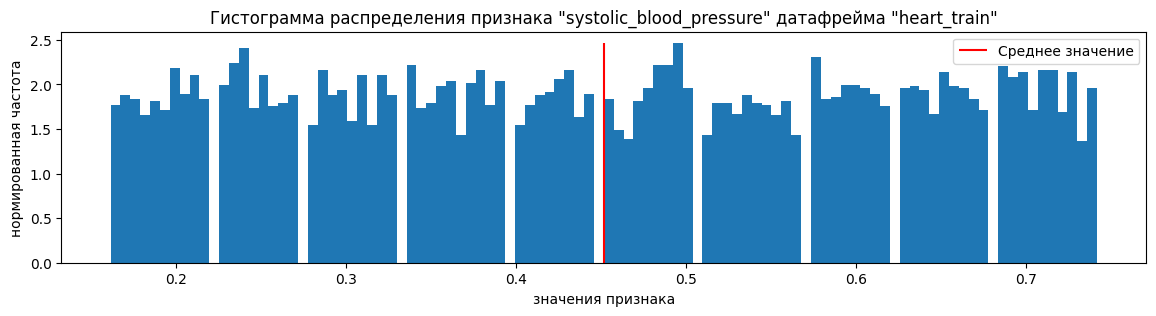

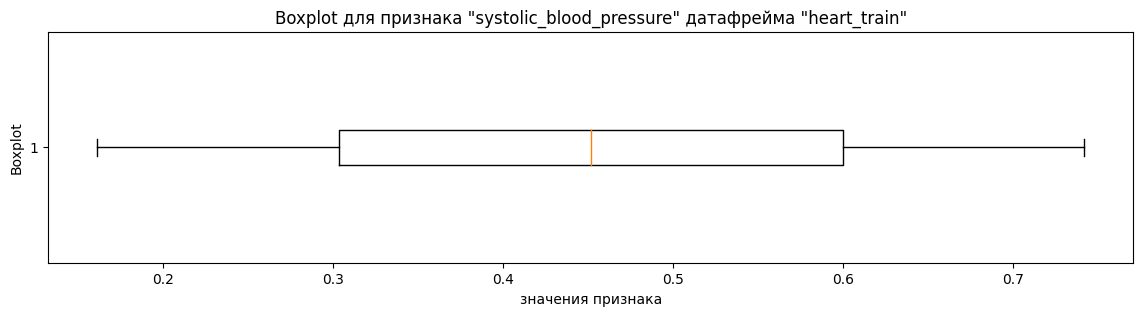

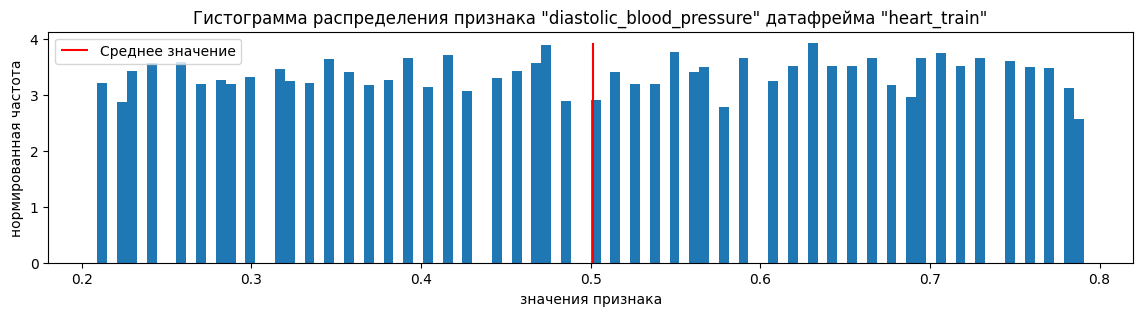

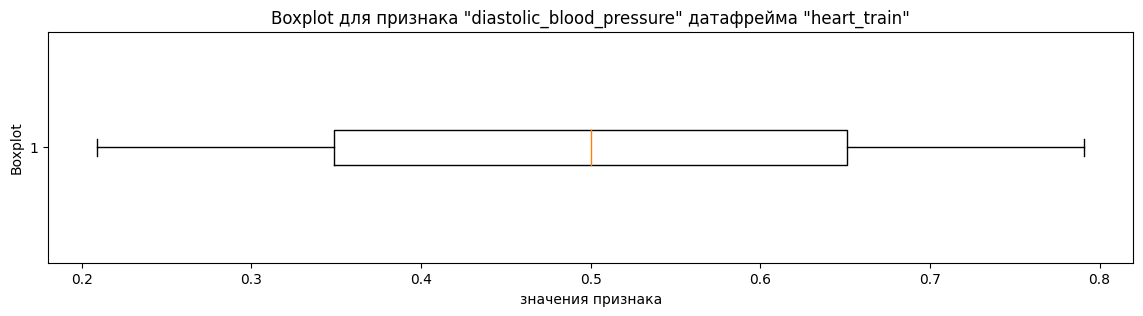

In [21]:
# вызов функции построения гистограмм распределения и Boxplot
number_hist(heart_train, 'heart_train')

#### Визуализация дискретных признаков

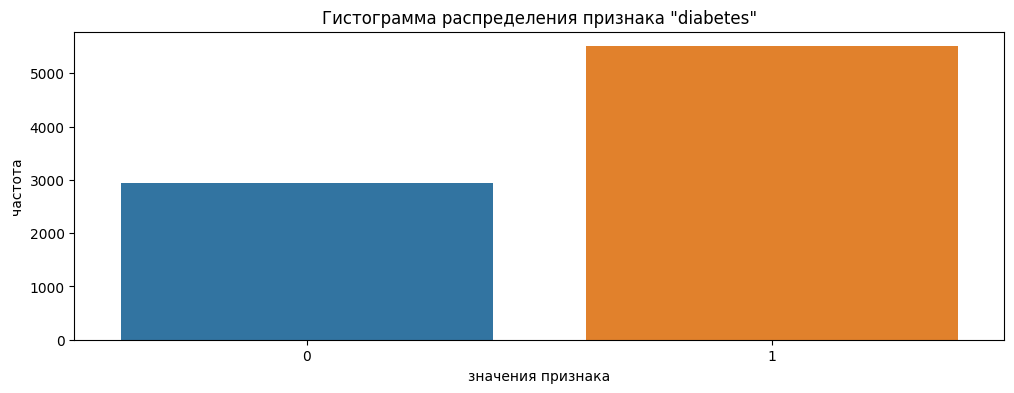

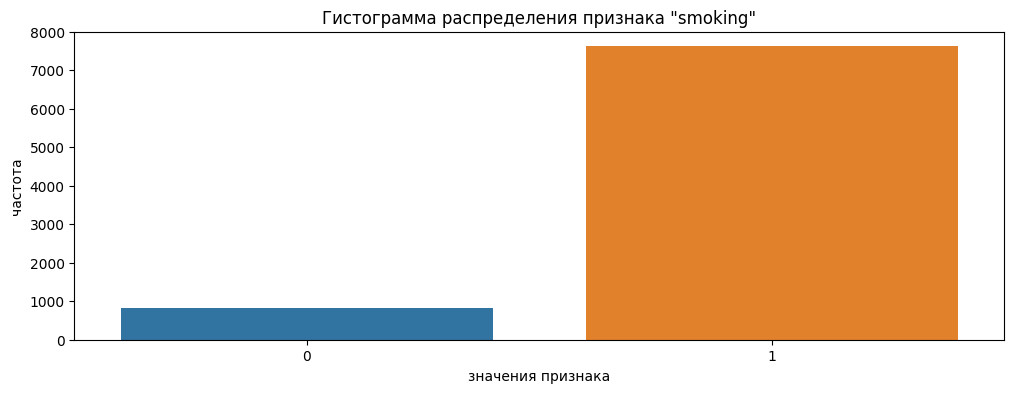

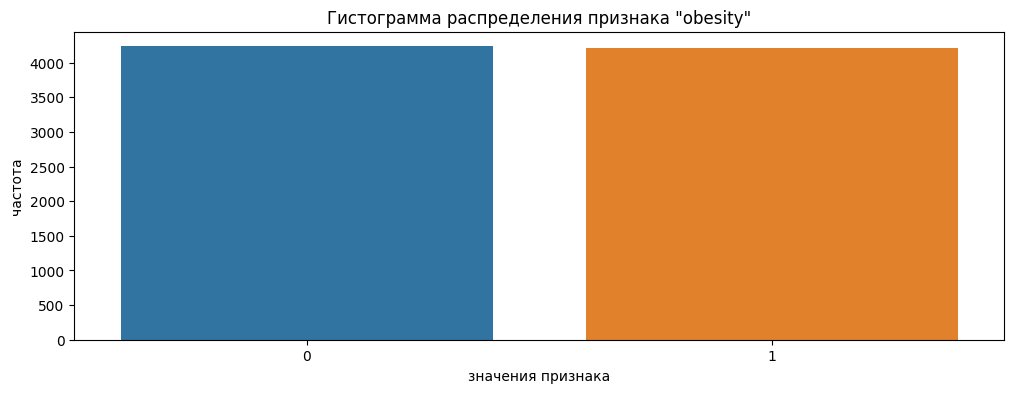

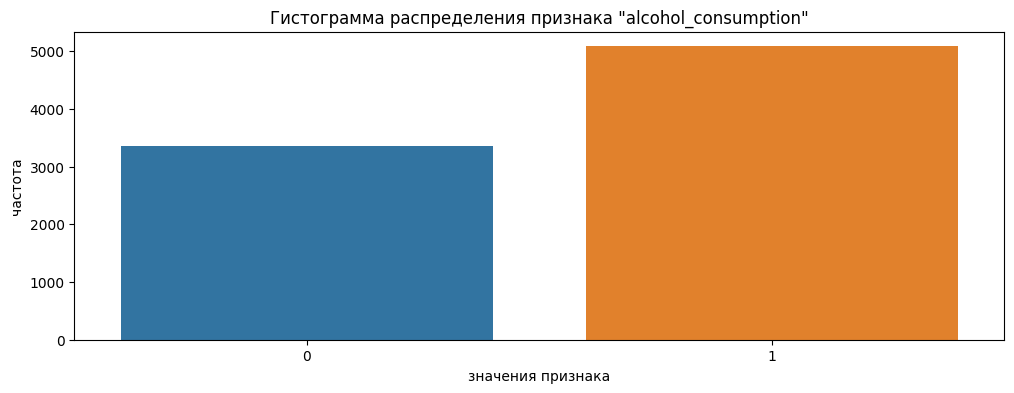

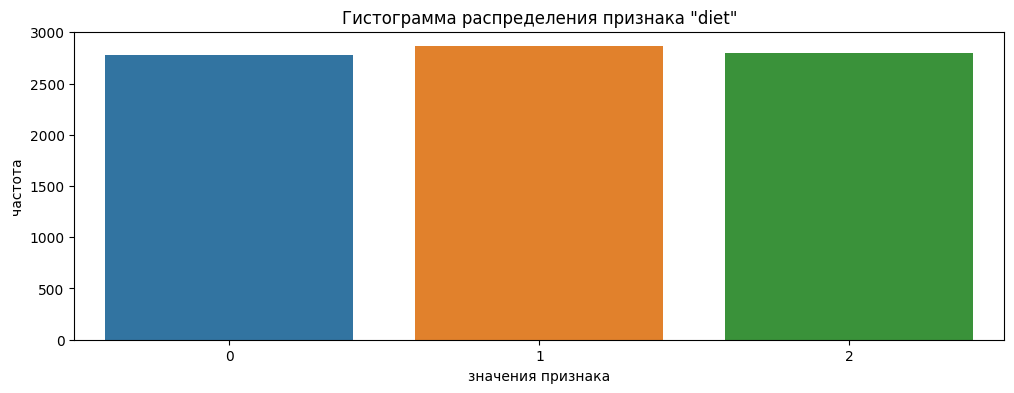

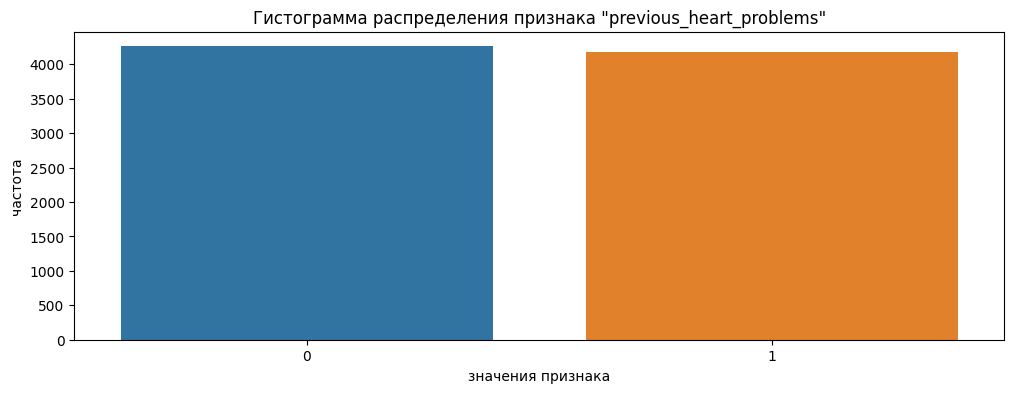

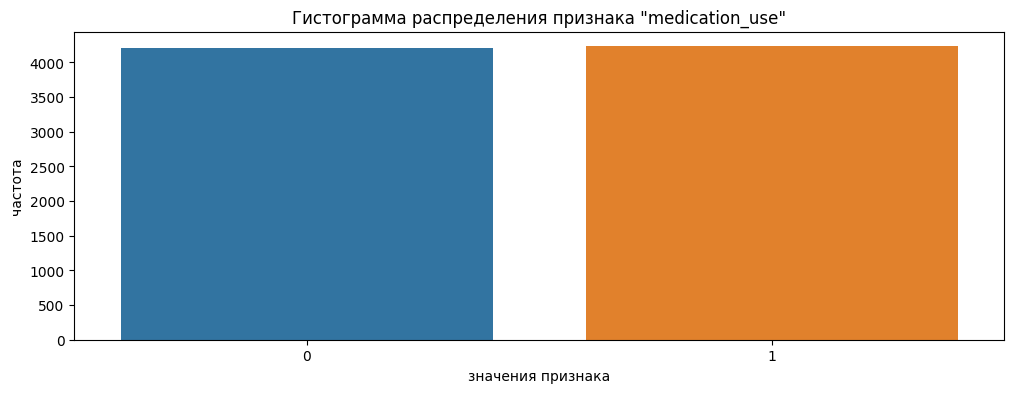

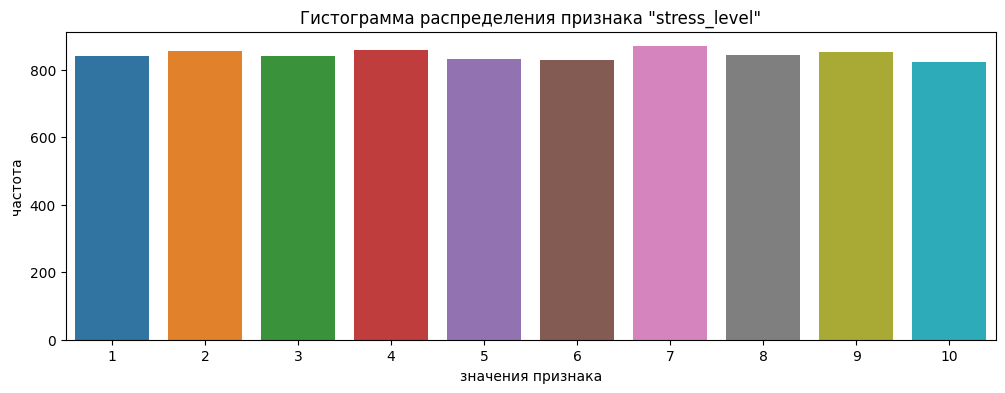

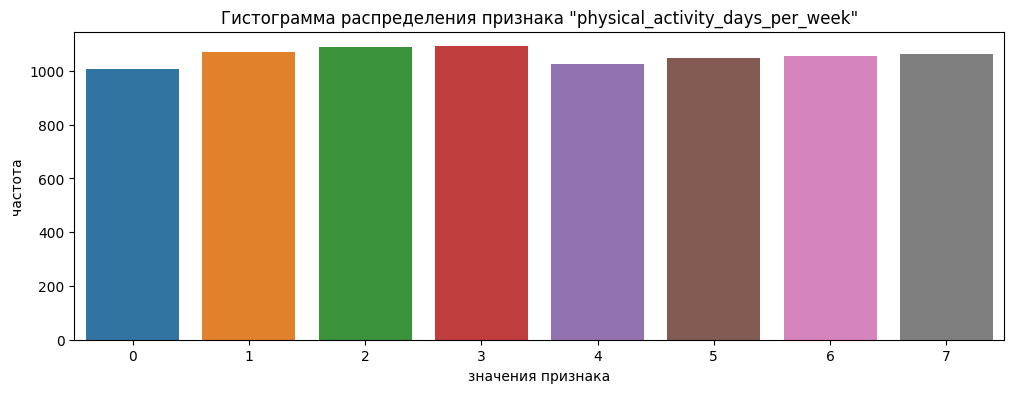

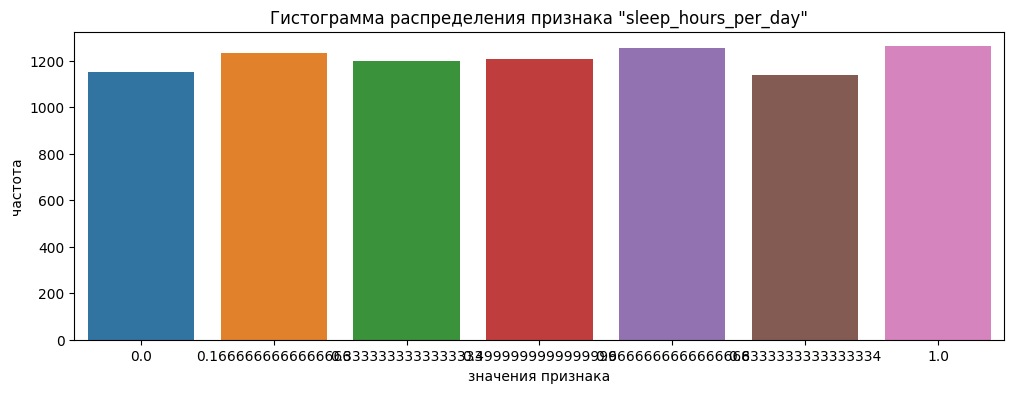

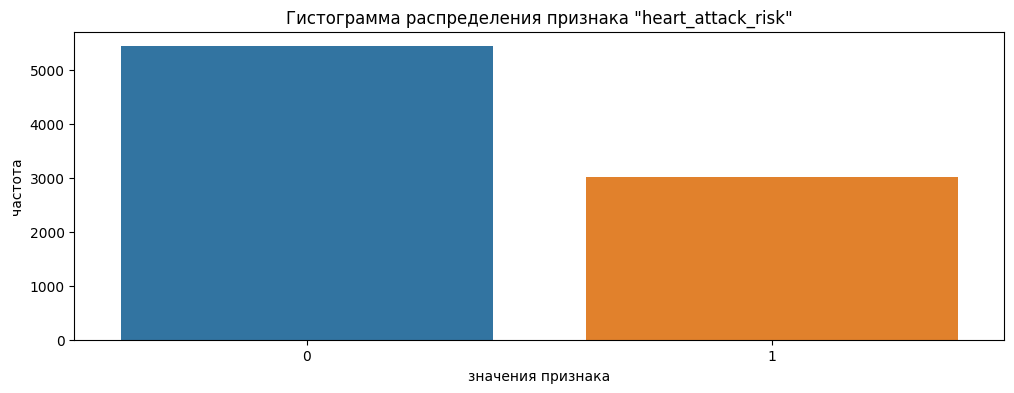

In [22]:
# вызов функции построения гистограмм дискретных признаков
discret_count(heart_train, ['diabetes', 'smoking', 'obesity', 'alcohol_consumption', 
                            'diet', 'previous_heart_problems', 'medication_use', 
                            'stress_level', 'physical_activity_days_per_week', 
                            'sleep_hours_per_day', 'heart_attack_risk'])

#### Визуализация категориального признака 'gender'

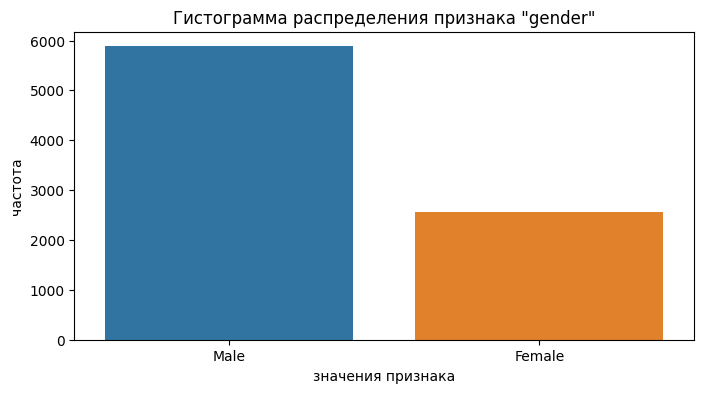

In [23]:
plt.figure(figsize=(8, 4))
sns.countplot(data=heart_train, x='gender'
             ).set_title(f'Гистограмма распределения признака "gender"')
plt.ylabel('частота')
plt.xlabel('значения признака');    

#### Корреляционный анализ тренировочного датафрейма heart_train

In [24]:
# количественные непрерывные признаки
interval_cols=['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 
               'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 
               'blood_sugar', 'ck_mb', 'troponin', 
               'systolic_blood_pressure', 'diastolic_blood_pressure']

In [25]:
heart_train.columns

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'smoking', 'obesity',
       'alcohol_consumption', 'exercise_hours_per_week', 'diet',
       'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk', 'blood_sugar', 'ck_mb', 'troponin', 'gender',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

In [26]:
# датафрейм для построения матрицы корреляции
train_heart_cor = heart_train[['age', 'cholesterol', 'heart_rate', 'diabetes', 'smoking', 'obesity',
                             'alcohol_consumption', 'exercise_hours_per_week', 'diet',
                             'previous_heart_problems', 'medication_use', 'stress_level',
                             'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
                             'physical_activity_days_per_week', 'sleep_hours_per_day',
                             'heart_attack_risk', 'blood_sugar', 'ck_mb', 'troponin', 'gender',
                             'systolic_blood_pressure', 'diastolic_blood_pressure']]

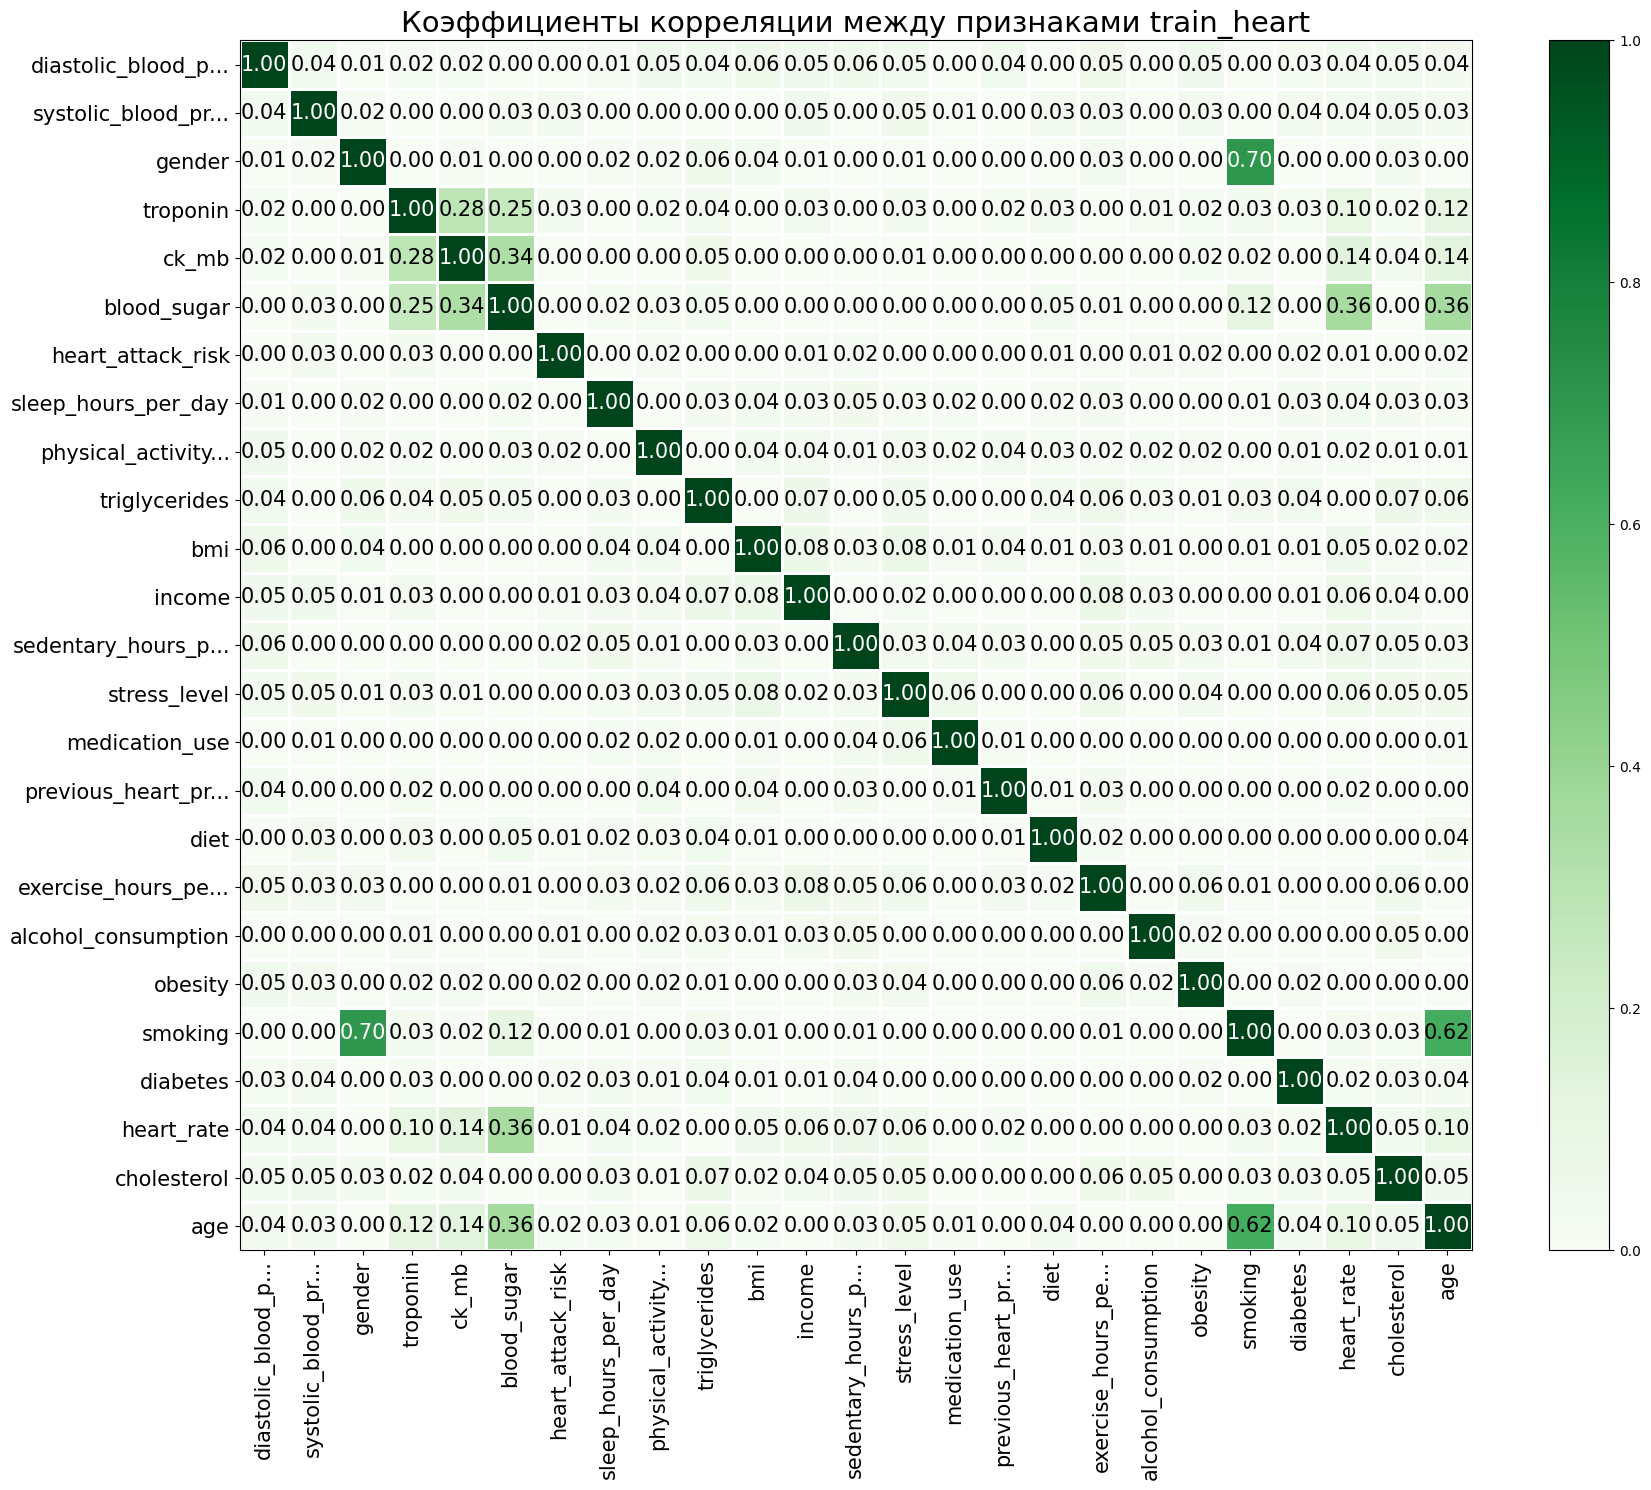

In [27]:
# расчет матрицы корреляции
phik_overview = train_heart_cor.phik_matrix(interval_cols=interval_cols)

# вывод матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Коэффициенты корреляции между признаками train_heart',
    fontsize_factor=1.5,
    figsize=(18, 15)
) 

In [28]:
# проверка на мультиколлинеарность по VIF
vif_data = pd.DataFrame()
train_heart_vif = train_heart_cor[['age', 'cholesterol', 'heart_rate', 'diabetes', 'smoking', 'obesity',
                                   'alcohol_consumption', 'exercise_hours_per_week', 'diet',
                                   'previous_heart_problems', 'medication_use', 'stress_level',
                                   'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
                                   'physical_activity_days_per_week', 'sleep_hours_per_day',
                                   'heart_attack_risk', 'blood_sugar', 'ck_mb', 'troponin', 
                                   'systolic_blood_pressure', 'diastolic_blood_pressure']]
vif_data['ПРИЗНАКИ     '] = train_heart_vif.columns

# вычисление VIF для каждого признака
vif_data['VIF'] = [variance_inflation_factor(train_heart_vif.values, i) for i in range(len(train_heart_vif.columns))]

print(vif_data)

                      ПРИЗНАКИ        VIF
0                               age  5.56
1                       cholesterol  3.89
2                        heart_rate  7.61
3                          diabetes  2.81
4                           smoking 11.26
5                           obesity  1.97
6               alcohol_consumption  2.46
7           exercise_hours_per_week  3.89
8                              diet  2.47
9           previous_heart_problems  1.96
10                   medication_use  1.98
11                     stress_level  4.44
12          sedentary_hours_per_day  3.87
13                           income  3.82
14                              bmi  3.88
15                    triglycerides  3.88
16  physical_activity_days_per_week  3.29
17              sleep_hours_per_day  3.21
18                heart_attack_risk  1.55
19                      blood_sugar  9.29
20                            ck_mb  1.45
21                         troponin  1.39
22          systolic_blood_pressur

#### ВЫВОДЫ:

**1.** Большая часть признаков представляет собой отнормированные в диапазоне от 0 до 1 либо дискретные значения.

**2.** Выбросы, аномалии, пропуски в подготовленном для МО датафрейме *train_heart* отсутствуют.

**3.** Большинство количественных признаков имеют распределение, близкое к равномерному.

**4.** Дисбаланс классов (существенное различие, в разы) в целевом признаке *'heart_attack_risk'* отсутствует.

**5.** Высокая связь выявлена между признаками *'smoking' и 'gender' (0,70), 'smoking' и 'age' (0,62)*, заметная связь - между признаками *'heart_rate' и 'blood_sugar' (0,36), 'age' и 'blood_sugar' (0,36)*.

**6.** Мультиколлинеарность между признаками датафрейма *train_heart* отсутствует (VIF-проверка).

**7.** Утечка данных отсутствует.

## Обучение модели

### Подготовка тренировочных и валидационных выборок

#### Удаление идентификационных id номеров и дубликатов из тренировочной выборки

In [29]:
# удаление идентификационных номеров из heart_train
heart_train = heart_train.drop(columns=['id'])

In [30]:
# проверка X_train на наличие полных дубликатов
heart_train.duplicated().sum()

0

In [31]:
# удаление полных дубликатов
heart_train = heart_train.drop_duplicates()

# проверка удаления столбцов и полных дубликатов
heart_train.shape

(8442, 25)

In [32]:
# удаление идентификационных номеров из heart_test
heart_test_new = heart_test.drop(columns=['id'])

#### Разделение признаков на входные и целевой

In [33]:
# выделение входных и целевого признаков из heart_train
y = heart_train[['heart_attack_risk']]

# удаление признака id и целевого признака 'heart_attack_risk' из датафреймов heart_train и heart_test
X = heart_train.drop(columns=[
    'heart_attack_risk',
    #'gender',
    #'age', 
    #'cholesterol',
    #'heart_rate',
    'diabetes', # бин
    'smoking',  # бин
    'obesity',  # бин
    'alcohol_consumption', # бин
    #'exercise_hours_per_week',
    #'diet', 
    'previous_heart_problems', # бин
    'medication_use',          # бин
    'stress_level', 
    #'sedentary_hours_per_day', 
    #'income', 
    #'bmi', 
    #'triglycerides', 
    'physical_activity_days_per_week', 
    #'sleep_hours_per_day', 
    #'blood_sugar',
    #'ck_mb', 
    #'troponin',
    #'systolic_blood_pressure', 
    #'diastolic_blood_pressure'
])

columns_list = X.select_dtypes(include='number').columns.tolist()

#### Разбиение данных на тренировочные и валидационные выборки

In [34]:
# деление данных на тренировочные и валидационные, стратификация данных
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

#### Разделение входных признаков и их кодирование

In [35]:
# категориальные признаки
ohe_columns = [
    'gender'
]

# количественные признаки
num_columns = columns_list

In [36]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [37]:
# масштабирование количественных признаков
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Построение лучшей модели на основе LogisticRegression()

#### Подготовка пайплайна

In [38]:
# итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_distributions = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='saga',                   
            penalty= 'l1'
        )],
        'models__C': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        'preprocessor__num': [MinMaxScaler(), 'passthrough']  
    }
]

#### Подбор гиперпараметров и обучение модели

In [39]:
# подбор гиперпараметров
model = GridSearchCV(
    pipe_final, 
    param_distributions,
    cv = 5, 
    scoring = 'recall',
    n_jobs = -1
)

In [40]:
# обучение модели на тренировочной выборке
model.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['gender']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'cholesterol',
                                                                          'heart_rate'...
                                                                          'troponin',
                                                                          'systolic_blood_pressure',
                                                                          'diastolic_blood_pressure'])])),
                                       ('models',
                                        LogisticRegression(random_state=77))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(class_weight='balanced',
                                                        penalty='l1',
                                                        random_state=77,
                                                        solver='saga')],
                          'models__C': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
                          'preprocessor__num': [MinMaxScaler(),
                                                'passthrough']}],
             scoring='recall')

In [41]:
# метрика recall и параметры лучшей модели
print(f'Метрика recall лучшей модели: {model.best_score_:.2f}')
print()
print('Лучшая модель и её параметры:\n\n', model.best_estimator_)
print()
print(f'Гиперпараметры лучшей модели: {model.best_params_}')

Метрика recall лучшей модели: 0.49

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('num', 'passthrough',
                                                  ['age', 'cholestero

#### Метрики лучшей модели

In [42]:
y_valid_pred = model.best_estimator_.predict(X_valid)
y_valid_proba = model.best_estimator_.predict_proba(X_valid)[:,1]
print('МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ ДЛЯ ВАЛИДАЦИОННОЙ ВЫБОРКИ БЕЗ ПОРОГОВОЙ ОПТИМИЗАЦИИ:')
print(f'recall:  {recall_score(y_valid, y_valid_pred):.2f}')
print(f'ROC-AUC: {roc_auc_score(y_valid, y_valid_proba):.2f}')
print(f'accuracy:  {accuracy_score(y_valid, y_valid_pred):.2f}')
print(f'precision:  {precision_score(y_valid, y_valid_pred):.2f}')
print(f'f1:  {f1_score(y_valid, y_valid_pred):.2f}')

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ ДЛЯ ВАЛИДАЦИОННОЙ ВЫБОРКИ БЕЗ ПОРОГОВОЙ ОПТИМИЗАЦИИ:
recall:  0.47
ROC-AUC: 0.49
accuracy:  0.50
precision:  0.35
f1:  0.40


#### ВЫВОДЫ:

**1.** В качестве рабочей метрики для улучшения качества модели была использована метрика **recall**, поскольку критически важным представляется не ошибиться с предсказанием отсутствия риска сердечного приступа. Именно по этой метрике велся подбор гиперпараметров.

**2.** В процессе работы над проектом обучались такие модели как **DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, SVC**. Ни одна из моделей не показала сколь-либо приемлемый уровень качества. Так, например, для модели на основе **DecisionTreeClassifier** были достигнуты следующие максимально возможные значения метрик:

* recall:  0.44;
* ROC-AUC: 0.56;
* accuracy:  0.59;
* precision:  0.43;
* f1:  0.43.

**3.** Принимая во внимание вышесказанное, было принято решение об использования в качестве рабочей модели **LogisticRegression** с подборомм порогового значения для классификации рисков сердечных приступов в сторону достижения максимального значения метрики **recall**.

**4.** В пользу выбора **LogisticRegression** аргументом является отсутствие выбросов в значениях входящих признаков.

**5.** Для того, чтобы **логистическую регрессию** можно было использовать для предсказания рисков сердечных приступов по тестовой выюорке **heart_test**, из выборки входящих были удалены такие признаки как **'diabetes', 'smoking', 'obesity',  'alcohol_consumption', 'previous_heart_problems', 'medication_use',  'stress_level', 'physical_activity_days_per_week'**, содержащие пропуски в значениях. Как было обнаружено при изучении данных и подборе гиперпараметров для различных наборов признаков, построение моделей по 3-5 взятым наугад признакам дает прогнозирование приблизительно того же качества, что и при учете в процессе МО всех признаков.

**6.** В результате подбора гиперпараметров при МО на основе **LogisticRegression** без применения оптимального порогового значения классификации были получены следующие метрики на валидационной выборке:

* recall: 0.47
* ROC-AUC: 0.49;
* accuracy:  0.50;
* precision:  0.35;
* f1:  0.35.

**7.** Параметры лучшей модели: **'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=77,
                   solver='saga'), 'models__C': 44, 'preprocessor__num': 'passthrough'.**


**8.** Метрика **recall** при кросс-валидации:  **0.49**.

### Подбор порогового значения для улучшения качетсва модели

#### Построение матрицы ошибок по итогу примнения модели на валидационной выборке

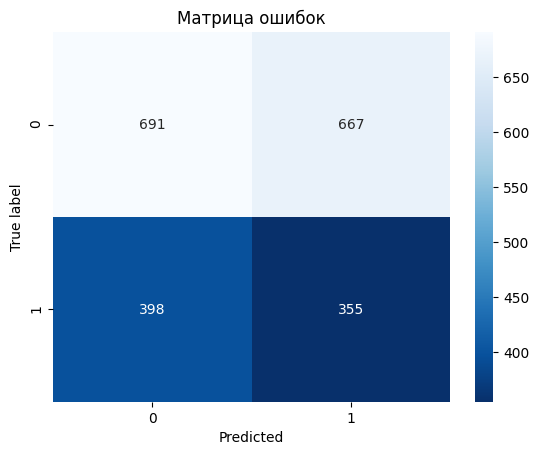

In [43]:
# графическое представление матрицы ошибок
cm = confusion_matrix(y_valid, y_valid_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

#### Оценка вероятности принадлежности значений валидационной выборки целевого признака к классу 

In [44]:
y_valid = np.array(y_valid)
y_valid_proba = np.array(y_valid_proba)
y_valid_proba

array([0.54382495, 0.52898988, 0.45322664, ..., 0.44848997, 0.47377659,
       0.46335093])

In [45]:
# построение таблицы с сопоставлением значений тестовой выборки и их вероятности
data = pd.DataFrame(zip(y_valid, y_valid_proba), 
                    columns = ['y_valid', 'y_valid_proba']).sort_values(by='y_valid_proba',ascending=False)

# проверка формирования таблицы
print(data.head(3)) 

     y_valid  y_valid_proba
555      [1]           0.68
1569     [0]           0.64
1267     [0]           0.64


#### Выставление пороговых значений для классификации значений валидационной выборки целевого признака

In [46]:
# задание пороговых значений для классификации
thresholds = [round(i,2) for i in np.linspace(0.41,0.46,num = 5, endpoint=False)]
print(thresholds) # проверка

[0.41, 0.42, 0.43, 0.44, 0.45]


In [47]:
# создание переменной, которая будет хранить список новых колонок
columns = []

# добавление столбцов с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_valid_pred_'+str(i))
    data['y_valid_pred_'+str(i)] = data['y_valid_proba'].apply(lambda x: 1 if x>=i else 0)

#### Подбор порогового значения для настройки модели по метрике recall

In [48]:
# нахождение порогового значения thresholds, при котором достигается recall=1
print()
print('Расчет  метрики recall для разных порогов:')
print()
print('порог:  recall:')

for i in thresholds:
    try: 
        recall = recall_score(y_valid, data['y_valid_pred_'+str(i)])
        print(f' {i}    {recall:.4f}')
    except:
        pass


Расчет  метрики recall для разных порогов:

порог:  recall:
 0.41    1.0000
 0.42    1.0000
 0.43    0.9947
 0.44    0.9841
 0.45    0.9575


#### Расчет итоговых метрик лучшей модели с учетом пороговой оптимизации

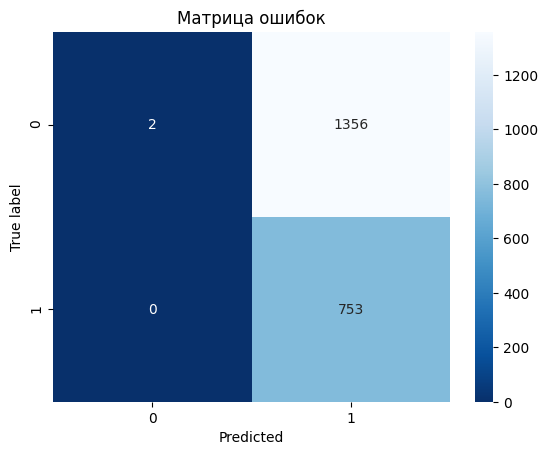

In [49]:
# графическое представление итоговой матрицы ошибок
cm = confusion_matrix(y_valid, data['y_valid_pred_0.42'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [50]:
# расчет  метрик для валидационной выборки при сведенной к 0 ошибки второго рода (recall=1, FN=1)
print('МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ ДЛЯ ВАЛИДАЦИОННОЙ ВЫБОРКИ ПРИ ПОРОГОВОЙ ОПТИМИЗАЦИИ:')
print('recall:   ', round(recall_score(y_valid, data['y_valid_pred_0.42']),2))
print('accuracy: ', round(accuracy_score(y_valid, data['y_valid_pred_0.42']),2))
print('precision:', round(precision_score(y_valid, data['y_valid_pred_0.42']),2))

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ ДЛЯ ВАЛИДАЦИОННОЙ ВЫБОРКИ ПРИ ПОРОГОВОЙ ОПТИМИЗАЦИИ:
recall:    1.0
accuracy:  0.36
precision: 0.36


#### ВЫВОДЫ:

**1.** В ходе подбора оптимального для классификации порогового значения вероятности сердечного приступа было достигнуто максимальное значение метрики **recall = 1** при пороговом значении **0.42**.

**2.** При этом значения других метрик качетсва модели составили:

* accuracy:  0.36;
* precision: 0.36.

## Предсказание на тестовой выборке, экспорт результатов

### Прогнозирование на тестовой выборке с учетом порога

#### Вычисление вероятности принадлежности к классу для тестовой выборки

In [51]:
# вычисление вероятности
y_test_proba = model.best_estimator_.predict_proba(heart_test_new)[:,1]

# проверка вычислений
y_test_proba[0:5]

array([0.48399401, 0.56724944, 0.49955145, 0.55467281, 0.50741422])

#### Создание датафрейма с предсказаниями для тестовой выборки

In [52]:
# создание датафрейма с предсказаниями для тестовой выборки
prediction = heart_test[['id']].join(pd.DataFrame(y_test_proba))

# переименование столбца
prediction.columns = ['id', 'pred_proba']

# формирование столбца с предсказаниями с учетом порогового значения
prediction['prediction'] = prediction['pred_proba'].apply(lambda x: .0 if x>=0.42 else 1.)

# проверка выполненных действий
prediction.head(2)

,id,pred_proba,prediction
0,7746,0.48,0.00
1,4202,0.57,0.00


In [53]:
# частота предсказания сердечного приступа на тестовой выборке
prediction['prediction'].value_counts()

0.00    965
1.00      1
Name: prediction, dtype: int64

### Экспорт результатов прогноза на тестовой выборке в файл .csv 

In [54]:
# удаление столбца с веротностями предсказания
prediction = prediction.drop(columns=['pred_proba'])
prediction.head(2)

,id,prediction
0,7746,0.00
1,4202,0.00


In [55]:
# экспорт файла с предсказаниями
prediction.to_csv('prediction.csv', index=False)

## ОБЩИЕ ВЫВОДЫ:

**1.** В ходе работы над проектом все значимые выводы собраны в п.п. 1.1.3, 1.2.4, 1.3.7, 2.2.4, 2.3.6.

**2.** В качестве рабочей метрики для построения лучшей модели с целью уменьшения ошибки второго рода (ошибочное предсказание отсутсвия риска сердечного приступа) для исследования была взята метрика **recall**, которая на валидационной выборке дала значение **0,47**.

**3.** Параметры лучшей модели: **'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=77, solver='saga'), 'models__C': 44, 'preprocessor__num': 'passthrough'.**

**4.** При подборе порогового значения для лучшей модели было достигнуто максимальное значение метрики качества **recall=1**, соответствующее порогу **0.42**. 

**5.** Примечательно, что при прогнозировании на основе построенной модели, из всей совокупности объектов тестовой выборки был выявлен только один случай наличия риска сердечного приступа, что может являться поводом для дальнейшего детального анализа модели на адекватность.